In [1]:
import numpy as np
import matplotlib.pyplot as plt
import galois
import itertools
from quantum_code import *
from classical_code import *
import stim
from scipy.sparse import lil_matrix
from tqdm import tqdm
from ldpc import BpDecoder, BpOsdDecoder
from ldpc.bplsd_decoder import BpLsdDecoder

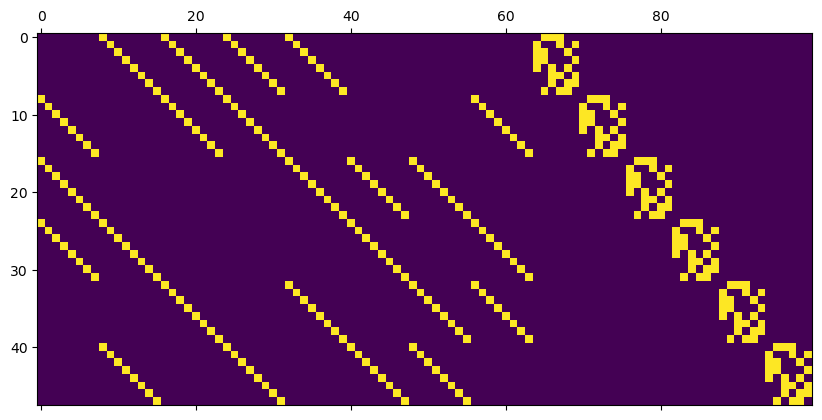

In [92]:
qcode = read_qcode("../codes/qcodes/HGP_100_4/HGP_100_4.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_100_4/HGP_C642_150_4.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_100_4/HGP_C422_200_4.qcode")

# qcode = read_qcode("../codes/qcodes/HGP_400_16/HGP_400_16.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_400_16/HGP_C642_600_16.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_400_16/HGP_C422_800_16.qcode")

# qcode = read_qcode("../codes/qcodes/HGP_900_36/HGP_900_36.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_900_36/HGP_C642_1350_36.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_900_36/HGP_C422_1800_36.qcode")

# qcode = read_qcode("../codes/qcodes/HGP_1600_64/HGP_1600_64.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_C642_2400_64.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_C422_3200_64.qcode")



# qcode = read_qcode("../codes/qcodes/BB_72_12.qcode")
# qcode = read_qcode("../codes/qcodes/BB_C422_144_12.qcode")
# qcode = read_qcode("../codes/qcodes/BB_C642_108_12.qcode")


# qcode = read_qcode("../codes/qcodes/BB_108_8.qcode")
# qcode = read_qcode("../codes/qcodes/BB_C642_162_8.qcode")

# qcode = read_qcode("../codes/qcodes/BB_144_12.qcode")
# qcode = read_qcode("../codes/qcodes/BB_C422_288_12.qcode")

# qcode = read_qcode("../codes/qcodes/BB_C422_576_24.qcode")


# concatenate_iceberg(qcode, 6, "../codes/qcodes/")
# concatenate_iceberg(qcode, 4, "../codes/qcodes/")
# concatenate_iceberg2(qcode, 6, "../codes/qcodes/")
# concatenate_iceberg2(qcode, 4, "../codes/qcodes/")


Hx, Hz, Lx, Lz, mapping = qcode.to_numpy()

qubit_error_rate = 0.001
meas_error_rate = 0.001

plt.matshow(Hx)

In [93]:
overlapping_x_generators = np.empty(qcode.qedxm, dtype=object)
for i in range(qcode.qedxm):
    tmp = np.array([], dtype=int)
    for j in range(qcode.qedxm,qcode.xm):
        if np.any(Hx[i] & Hx[j]): tmp = np.append(tmp, j)
    overlapping_x_generators[i] = tmp

overlapping_z_generators = np.empty(qcode.qedxm, dtype=object)
for i in range(qcode.qedzm):
    tmp = np.array([], dtype=int)
    for j in range(qcode.qedzm,qcode.zm):
        if np.any(Hz[i] & Hz[j]): tmp = np.append(tmp, j)
    overlapping_z_generators[i] = tmp

def get_overlapping(measurements, gen_type=False, not_overlapping=False):
    overlapping_generators = overlapping_x_generators if gen_type else overlapping_z_generators
    gens_to_measure = set()
    for g in np.where(measurements)[0]:
        gens_to_measure |= set(overlapping_generators[g])

    if not_overlapping:
        return np.array(list(set(np.arange(qcode.qedxm,qcode.xm)) ^ gens_to_measure))
    else:
        return np.array(list(gens_to_measure))

In [94]:
cn = qcode.n
cmx = qcode.xm
cmz = qcode.zm
# qedm, qedn = concatenatedStabilizersQED.shape
# qecm, qecn = concatenatedStabilizersXQEC.shape
data_qbts = np.arange(cn)
x_checks = np.arange(cn,cn+cmx)
z_checks = np.arange(cn+cmx,cn+cmx+cmz)
all_qbts = np.arange(cn+cmx+cmz)

precomputed_x_checks_circuits = np.empty(cmx, dtype=object)
for x in np.arange(qcode.xm):
    c = stim.Circuit()
    gen_qbts = data_qbts[np.where(Hx[x])[0]]
    for qbt in gen_qbts:
        path_qbts = [x_checks[x], qbt]
        c.append("CNOT", path_qbts)
        c.append("DEPOLARIZE2", path_qbts, qubit_error_rate)
    precomputed_x_checks_circuits[x] = c

def prepare_x_checks(checks):
    c = stim.Circuit()
    if len(checks) == 0: return c
    c.append("H", [x_checks[x_check] for x_check in checks])
    c.append("DEPOLARIZE1", [x_checks[x_check] for x_check in checks], qubit_error_rate)
    for x in checks:
        c += precomputed_x_checks_circuits[x]
    c.append("H", [x_checks[x_check] for x_check in checks])
    c.append("DEPOLARIZE1", [x_checks[x_check] for x_check in checks], qubit_error_rate)
    return c

precomputed_z_checks_circuits = np.empty(cmz, dtype=object)
for z in np.arange(qcode.zm):
    c = stim.Circuit()
    gen_qbts = data_qbts[np.where(Hz[z])[0]]
    for qbt in gen_qbts:
        path_qbts = [qbt, z_checks[z]]
        c.append("CNOT", path_qbts)
        c.append("DEPOLARIZE2", path_qbts, qubit_error_rate)
    precomputed_z_checks_circuits[z] = c

def prepare_z_checks(checks):
    c = stim.Circuit()
    if len(checks) == 0: return c
    for z in checks:
        c += precomputed_z_checks_circuits[z]
    return c

In [95]:
class Simulation:
    def __init__(self, num_rounds, stab_type, adaptive=True):
        self.num_rounds = num_rounds
        self.stab_type = stab_type
        self.curr_round = 1
        self.adaptive = adaptive

        self.prev_meas_z = np.zeros(cmz, dtype=int)
        self.prev_meas_x = np.zeros(cmx, dtype=int)
        self.curr_meas_z = np.zeros(cmz, dtype=int)
        self.curr_meas_x = np.zeros(cmx, dtype=int)

        self.z_check_history = np.ones(cmz, dtype=int)
        self.x_check_history = np.ones(cmx, dtype=int)
        self.z_syndrome_history = np.zeros(shape=(num_rounds+2, cmz), dtype=int)
        self.x_syndrome_history = np.zeros(shape=(num_rounds+2, cmx), dtype=int)
        self.z_observables = np.zeros(qcode.k, dtype=int)
        self.x_observables = np.zeros(qcode.k, dtype=int)

        self.c = stim.Circuit()
        self.c.append("M", 0) # hacky way to make detectors that aren't affected by anything
        self.s = stim.TableauSimulator()

        if self.stab_type:
            self.c.append("H", [qbt for qbt in data_qbts])
            self.c += prepare_z_checks(np.arange(cmz)).without_noise()
            # self.c.append("X_ERROR", z_checks, meas_error_rate)
            for i, z_check in enumerate(np.arange(cmz)):
                self.c.append("MR", z_checks[z_check])
                self.prev_meas_z[z_check] = self.c.num_measurements
            # self.c.append("X_ERROR", z_checks, meas_error_rate)
        else:
            self.c += prepare_x_checks(np.arange(cmx)).without_noise()
            # self.c.append("X_ERROR", x_checks, meas_error_rate)
            for i, x_check in enumerate(np.arange(cmx)):
                self.c.append("MR", x_checks[x_check])
                self.prev_meas_x[x_check] = self.c.num_measurements
            # self.c.append("X_ERROR", x_checks, meas_error_rate)

        self.s.do_circuit(self.c)
        if self.stab_type:
            self.z_syndrome_history[0] = self.s.current_measurement_record()[1:]
        else:
            self.x_syndrome_history[0] = self.s.current_measurement_record()[1:]


    def detectors(self):
        num_meas = self.c.num_measurements
        prev_meas = self.prev_meas_x if self.stab_type else self.prev_meas_z
        curr_meas = self.curr_meas_x if self.stab_type else self.curr_meas_z

        for i, check in enumerate(np.arange(cmz)):
            if not prev_meas[i]:
                self.c.append("DETECTOR", [stim.target_rec(curr_meas[i]-num_meas-1)] if curr_meas[i] else [stim.target_rec(-num_meas)], (i,self.curr_round))
            else:
                self.c.append("DETECTOR", [stim.target_rec(curr_meas[i]-num_meas-1), stim.target_rec(prev_meas[i]-num_meas-1)] if curr_meas[i] else [stim.target_rec(-num_meas)], (i,self.curr_round))
            if curr_meas[i]:
                prev_meas[i] = curr_meas[i]
                curr_meas[i] = 0

        if self.stab_type:
            self.prev_meas_x = prev_meas
            self.curr_meas_x = curr_meas
        else:
            self.prev_meas_z = prev_meas
            self.curr_meas_z = curr_meas

    def final_detectors_and_observables(self):
        c = stim.Circuit()

        if self.stab_type: c.append("H", [qbt for qbt in data_qbts])
        c.append("M", [qbt for qbt in data_qbts])

        self.s.do_circuit(c)

        meas = self.s.current_measurement_record()
        num_meas = self.c.num_measurements + c.num_measurements
        H = Hx if self.stab_type else Hz
        prev_meas = self.prev_meas_x if self.stab_type else self.prev_meas_z
        for i in range(H.shape[0]):
            incl_qbts = np.where(H[i])[0]
            incl_qbts = [j-cn for j in incl_qbts]
            target_recs = [stim.target_rec(j) for j in incl_qbts]

            if prev_meas[i]:
                target_recs.append(stim.target_rec(prev_meas[i]-num_meas-1))
            c.append("DETECTOR", target_recs, (i, self.curr_round))

            if self.stab_type:
                self.x_syndrome_history[-1][i] = np.sum(np.take(meas, incl_qbts)) % 2
            else:
                self.z_syndrome_history[-1][i] = np.sum(np.take(meas, incl_qbts)) % 2

        for i, logical in enumerate(Lx if self.stab_type else Lz):
            incl_qbts = np.where(logical)[0]
            incl_qbts = [j-cn for j in incl_qbts]
            c.append("OBSERVABLE_INCLUDE", [stim.target_rec(j) for j in incl_qbts], i)

            if self.stab_type:
                self.x_observables[i] = np.sum(np.take(meas, incl_qbts)) % 2
            else:
                self.z_observables[i] = np.sum(np.take(meas, incl_qbts)) % 2
        return c

    def QED(self):
        def measure_z_qed_checks(c):
            c += prepare_z_checks(np.arange(qcode.qedzm))
            c.append("X_ERROR", [z_checks[z_check] for z_check in np.arange(qcode.qedzm)], meas_error_rate)
            for i, z_check in enumerate(np.arange(qcode.qedzm)):
                c.append("MR", z_checks[z_check])
                self.curr_meas_z[z_check] = self.c.num_measurements + c.num_measurements
            c.append("X_ERROR", [z_checks[z_check] for z_check in np.arange(qcode.qedzm)], meas_error_rate)
            return c

        def measure_x_qed_checks(c):
            c += prepare_x_checks(np.arange(qcode.qedxm))
            c.append("X_ERROR", [x_checks[x_check] for x_check in np.arange(qcode.qedxm)], meas_error_rate)
            for i, x_check in enumerate(np.arange(qcode.qedxm)):
                c.append("MR", x_checks[x_check])
                self.curr_meas_x[x_check] = self.c.num_measurements + c.num_measurements
            c.append("X_ERROR", [x_checks[x_check] for x_check in np.arange(qcode.qedxm)], meas_error_rate)
            return c

        c = stim.Circuit()
        if self.stab_type:
            c = measure_x_qed_checks(c)
            c = measure_z_qed_checks(c)
        else:
            c = measure_z_qed_checks(c)
            c = measure_x_qed_checks(c)
        return c

    def QEC(self):
        def measure_z_qec_checks(c, curr_z_checks):
            c += prepare_z_checks(curr_z_checks)
            c.append("X_ERROR", [z_checks[z_check] for z_check in curr_z_checks], meas_error_rate)
            for i, z_check in enumerate(curr_z_checks):
                c.append("MR", z_checks[z_check])
                self.curr_meas_z[z_check] = self.c.num_measurements + c.num_measurements
            c.append("X_ERROR", [z_checks[z_check] for z_check in curr_z_checks], meas_error_rate)
            return c

        def measure_x_qec_checks(c, curr_x_checks):
            c += prepare_x_checks(curr_x_checks)
            c.append("X_ERROR", [x_checks[x_check] for x_check in curr_x_checks], meas_error_rate)
            for i, x_check in enumerate(curr_x_checks):
                c.append("MR", x_checks[x_check])
                self.curr_meas_x[x_check] = self.c.num_measurements + c.num_measurements
            c.append("X_ERROR", [x_checks[x_check] for x_check in curr_x_checks], meas_error_rate)
            return c

        c = stim.Circuit()
        if self.stab_type:
            c = measure_x_qec_checks(c, self.curr_x_checks)
            c = measure_z_qec_checks(c, self.curr_z_checks)
        else:
            c = measure_z_qec_checks(c, self.curr_z_checks)
            c = measure_x_qec_checks(c, self.curr_x_checks)
        return c

    def simulate(self):
        for i in range(1, self.num_rounds+1):
            if self.stab_type:
                self.c.append("Z_ERROR", data_qbts, qubit_error_rate)
                self.s.z_error(*data_qbts, p=qubit_error_rate)
            else:
                self.c.append("X_ERROR", data_qbts, qubit_error_rate)
                self.s.x_error(*data_qbts, p=qubit_error_rate)

            self.z_syndrome_history[self.curr_round] = self.z_syndrome_history[self.curr_round-1]
            self.x_syndrome_history[self.curr_round] = self.x_syndrome_history[self.curr_round-1]
            self.curr_z_checks = np.zeros(cmz)
            self.curr_x_checks = np.zeros(cmx)

            if not self.adaptive:
                self.curr_z_checks = np.arange(cmz)
                self.curr_x_checks = np.arange(cmx)
            else:
                QED_circuit = self.QED()
                self.s.do_circuit(QED_circuit)
                self.c += QED_circuit

                # determining which of the QEC stabilizers to measure
                meas = self.s.current_measurement_record()
                if self.stab_type:
                    self.x_syndrome_history[self.curr_round][:qcode.qedxm] = meas[-(qcode.qedxm+qcode.qedzm):-qcode.qedxm]
                    self.z_syndrome_history[self.curr_round][:qcode.qedzm] = meas[-qcode.qedzm:]
                else:
                    self.z_syndrome_history[self.curr_round][:qcode.qedzm] = meas[-(qcode.qedzm+qcode.qedxm):-qcode.qedzm]
                    self.x_syndrome_history[self.curr_round][:qcode.qedxm] = meas[-qcode.qedxm:]

                z_qed_synd_diff = self.z_syndrome_history[self.curr_round-1][:qcode.qedzm] ^ self.z_syndrome_history[self.curr_round][:qcode.qedzm]
                x_qed_synd_diff = self.x_syndrome_history[self.curr_round-1][:qcode.qedxm] ^ self.x_syndrome_history[self.curr_round][:qcode.qedxm]

                self.curr_z_checks = sorted(get_overlapping(z_qed_synd_diff, False))
                self.curr_x_checks = sorted(get_overlapping(x_qed_synd_diff, True))


            confirmation_z = np.concatenate([np.ones(qcode.qedzm, dtype=int), np.zeros(cmz-qcode.qedzm, dtype=int)])
            confirmation_z[self.curr_z_checks] = 1
            confirmation_x = np.concatenate([np.ones(qcode.qedxm, dtype=int), np.zeros(cmx-qcode.qedxm, dtype=int)])
            confirmation_x[self.curr_x_checks] = 1
            self.z_check_history = np.vstack([self.z_check_history, confirmation_z])
            self.x_check_history = np.vstack([self.x_check_history, confirmation_x])

            QEC_circuit = self.QEC()
            self.s.do_circuit(QEC_circuit)
            self.c += QEC_circuit

            meas = self.s.current_measurement_record()
            lookback = lambda x: -len(x) if len(x) else None
            if self.stab_type:
                if len(self.curr_x_checks):
                    self.x_syndrome_history[self.curr_round][self.curr_x_checks] = meas[lookback(np.concatenate([self.curr_x_checks, self.curr_z_checks])):
                                                                          lookback(self.curr_z_checks)]
                if len(self.curr_z_checks):
                    self.z_syndrome_history[self.curr_round][self.curr_z_checks] = meas[lookback(self.curr_z_checks):]
            else:
                if len(self.curr_z_checks):
                    self.z_syndrome_history[self.curr_round][self.curr_z_checks] = meas[lookback(np.concatenate([self.curr_z_checks, self.curr_x_checks])):
                                                                          lookback(self.curr_x_checks)]
                if len(self.curr_x_checks):
                    self.x_syndrome_history[self.curr_round][self.curr_x_checks] = meas[lookback(self.curr_x_checks):]

            self.detectors()
            self.curr_round += 1

        obs_circuit = self.final_detectors_and_observables()
        self.c += obs_circuit

In [96]:
stab_type = True
adaptive = True if qcode.qedxm else False
adaptive = False

num_rounds = 10
s = Simulation(num_rounds, stab_type, adaptive=adaptive)
s.simulate()
c = s.c

In [97]:
sampler = c.compile_detector_sampler()
dem = c.detector_error_model()
pcm = lil_matrix((dem.num_detectors, dem.num_errors), dtype=int)
lcm = lil_matrix((dem.num_observables, dem.num_errors), dtype=int)

errors = []
channel_probs = [e.args_copy()[0] for e in dem if e.type=="error"]
for i, error_event in enumerate(c.explain_detector_error_model_errors()):
    dets = [det.dem_target.val for det in error_event.dem_error_terms if det.dem_target.is_relative_detector_id()]
    obs = [ob.dem_target.val for ob in error_event.dem_error_terms if ob.dem_target.is_logical_observable_id()]
    pcm[[dets],i] = 1
    lcm[[obs],i] = 1

print(pcm.shape)
print(lcm.shape)
print(len(channel_probs))

bposd_dec = BpLsdDecoder(
    pcm.A,
    channel_probs=channel_probs,
    max_iter=30,
    bp_method="ps",
    # ms_scaling_factor=0,
    osd_method="osd0",
    # osd_order=2
)


successes = 0
for ii in tqdm(range(100)):
    detection_events, observable_flips = sampler.sample(1, separate_observables=True)
    guessed_errors = bposd_dec.decode(detection_events[0])

    guessed_obs = (lcm @ guessed_errors) % 2
    success = np.all(observable_flips[0].astype(int) == guessed_obs)
    successes += success

successes

(528, 5800)
(4, 5800)
5800


100%|██████████| 100/100 [00:00<00:00, 107.94it/s]


95

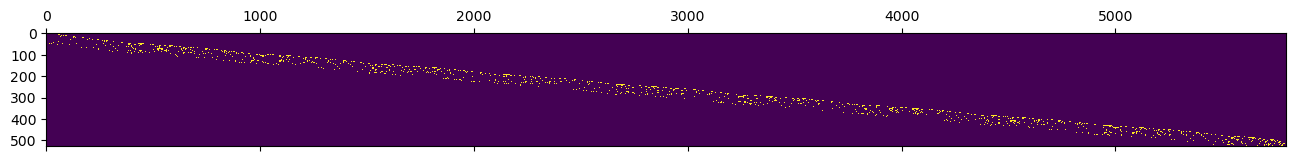

In [41]:
plt.matshow(pcm.A)

In [72]:
stab_type = True
adaptive = True if qcode.qedxm else False
num_rounds = 10

no_gens = []

# np.random.seed(4)

successes = 0
for ii in tqdm(range(100)):
    s = Simulation(num_rounds, stab_type, adaptive=adaptive)
    s.simulate()
    c = s.c

    z_detection_events = np.array([s.z_syndrome_history[i] ^ s.z_syndrome_history[i+1] for i in range(num_rounds+1)]).flatten()
    x_detection_events = np.array([s.x_syndrome_history[i] ^ s.x_syndrome_history[i+1] for i in range(num_rounds+1)]).flatten()
    detection_events = x_detection_events if stab_type else z_detection_events
    observable_flips = s.x_observables if stab_type else s.z_observables

    # sampler = c.compile_detector_sampler()
    dem = c.detector_error_model()
    pcm = lil_matrix((dem.num_detectors, dem.num_errors), dtype=int)
    lcm = lil_matrix((dem.num_observables, dem.num_errors), dtype=int)

    errors = []
    channel_probs = [e.args_copy()[0] for e in dem if e.type=="error"]
    for i, error_event in enumerate(c.explain_detector_error_model_errors()):
        dets = [det.dem_target.val for det in error_event.dem_error_terms if det.dem_target.is_relative_detector_id()]
        obs = [ob.dem_target.val for ob in error_event.dem_error_terms if ob.dem_target.is_logical_observable_id()]
        pcm[[dets],i] = 1
        lcm[[obs],i] = 1

    # print((str(c).count("CX") - 3) / num_rounds)


    bposd_dec = BpLsdDecoder(
        pcm.A,
        channel_probs=channel_probs,
        max_iter=30,
        bp_method="ps",
        # ms_scaling_factor=0,
        lsd_method="lsd_cs",
        lsd_order=2
    )


    guessed_errors = bposd_dec.decode(detection_events)
    guessed_obs = (lcm @ guessed_errors) % 2
    success = np.all(observable_flips.astype(int) == guessed_obs)
    successes += success

successes

100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


68